#Starting Spark session and Importing Data

In [ ]:
!pip install pyspark # installing pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # installing java
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz # install hadoop
!tar xf spark-3.1.1-bin-hadoop2.7.tgz # unzip hadoop
!pip install -q findspark # install findspark

     |████████████████████████████████| 212.3MB 65kB/s 
     |████████████████████████████████| 204kB 16.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=57be92d0e627ecdb03a61cba227abf70936d127f3e05faa6371537ec7c07a92e
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
# Start a pyspark sesssion
import findspark
findspark.init() # initialise findspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() # start a spark session

In [ ]:
import pyspark
from pyspark.sql.functions import  *
from pyspark.sql.window import Window

In [ ]:
# get the data
!wget "https://www.dropbox.com/s/cck1sazb7zh1bjy/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip?dl=0"

--2021-05-27 15:27:05--  https://www.dropbox.com/s/cck1sazb7zh1bjy/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cck1sazb7zh1bjy/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip [following]
--2021-05-27 15:27:05--  https://www.dropbox.com/s/raw/cck1sazb7zh1bjy/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08ac89e87d54b59b93b8585d05.dl.dropboxusercontent.com/cd/0/inline/BPScumjgR7s37fOp4k2KfHQx6ZCXMqllGEOoe6QhywUwGnl7hlXI45EOTCncFwCyhJm_BqKA4PaKzLWI3M-Y4XE0CxenYQj9CXcA7-EGMcAZnyYhYmIvwyWgsjYJnV75vrUd8EeoymmsiFtgoBxrAhOG/file# [following]
--2021-0

In [ ]:
# unzip the data
!unzip /content/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip?dl=0

Archive:  /content/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet.zip?dl=0
  inflating: part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet  
  inflating: __MACOSX/._part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet  


# Data Preparation

In [ ]:
data = spark.read.parquet("/content/part-00008-5534048d-b0e9-4780-b318-5b630d863d04-c000.snappy.parquet") # Reading the parquet file

In [ ]:
data.show(10) # show first 10 rows

+-------------------+-------+-------------------------+---------------+--------+--------+----+----+-------------------+---------------------+--------+------------+----------+--------------+------+-----------------------+-------------+-------------------+---------+---------------+--------+--------------------+-----------+--------+------+--------------+-------------------+---------------+--------------------+--------------+--------------+--------------------+--------------------+-----------------------+-------------------+---------------------+--------------------+-------------------+------------+---------+--------+-------+------------+---------+-------------------+-------------+-------------------+----------------------+-------------------------+------------------------------+--------+------------+---------------------------+----------------+-----------------+-------------------+------------------------+---------------------------+-----------------------+------------+--------------+----

In [ ]:
#Generate frequency of customers across brands

#1. Partition the data by cid and clean_brand
#2. Create a new column containing frequencies of customers across brands

window_spec_1 = Window.partitionBy('cid', 'clean_brand')
data = data.withColumn('frequency_across_brands', count(col('clean_brand')).over(window_spec_1).alias('frequency_across_brands'))

#Remove the duplicates
updated_data = data.groupby('cid', 'clean_brand').agg(first('frequency_across_brands').alias('frequency_across_brands'))

#Generate percentile_rank based upon brand and frequency across custoemr

window_spec_2 = Window.partitionBy('clean_brand').orderBy('frequency_across_brands')
updated_data = updated_data.withColumn('percentile_rank', percent_rank().over(window_spec_2))

#Generate ratings based on the percentile rank

final_data = updated_data.selectExpr("*", "CASE WHEN percentile_rank <= 0.25 THEN 1 WHEN percentile_rank > 0.25 AND percentile_rank <= 0.50 THEN 2 WHEN percentile_rank > 0.50 AND percentile_rank <= 0.75 THEN 3 WHEN percentile_rank > 0.75 AND percentile_rank <= 0.90 THEN 4 ELSE 5 END AS ratings")

In [ ]:
final_data.show(10)

+-------------------+--------------------+-----------------------+---------------+-------+
|                cid|         clean_brand|frequency_across_brands|percentile_rank|ratings|
+-------------------+--------------------+-----------------------+---------------+-------+
|0218083012206448792|Association of Ch...|                      2|            0.0|      1|
|0231051004738310108|               Bismi|                      1|            0.0|      1|
|0208111005761100213|               Bismi|                      1|            0.0|      1|
|0213021017392991706|               Bismi|                      2|            0.5|      2|
|0208061022120241935|               Bismi|                      2|            0.5|      2|
|0208101026491350493|               Bismi|                      3|            1.0|      5|
|0217070004530371036|   City Super Bazaar|                      1|            0.0|      1|
|0205081011354180052|   City Super Bazaar|                      2|            0.5|      2|

In [ ]:
# Printing count for each rating
rating_1_count = final_data.filter(col('ratings') == 1).count()
rating_2_count = final_data.filter(col('ratings') == 2).count()
rating_3_count = final_data.filter(col('ratings') == 3).count()
rating_4_count = final_data.filter(col('ratings') == 4).count()
rating_5_count = final_data.filter(col('ratings') == 5).count()

print("Number of customers with rating as 1 are {}".format(rating_1_count))
print("Number of customers with rating as 2 are {}".format(rating_2_count))
print("Number of customers with rating as 3 are {}".format(rating_3_count))
print("Number of customers with rating as 4 are {}".format(rating_4_count))
print("Number of customers with rating as 5 are {}".format(rating_5_count))

Number of customers with rating as 1 are 78490
Number of customers with rating as 2 are 4529
Number of customers with rating as 3 are 7996
Number of customers with rating as 4 are 5044
Number of customers with rating as 5 are 3987


In [ ]:
# Create the final trainig data
full_training_data = final_data.select('cid', 'clean_brand', 'ratings')

In [ ]:
# Check for null values
full_training_data.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in full_training_data.columns]).show()

+---+-----------+-------+
|cid|clean_brand|ratings|
+---+-----------+-------+
|  0|      55406|      0|
+---+-----------+-------+



In [ ]:
# print the percentage null values
total_null_vals = full_training_data.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in full_training_data.columns]).collect()[0][1]
total_vals = full_training_data.count()

# Find the percentage of null vals
perc_null_vals = float(total_null_vals)*100/total_vals
print("Percentage of null values in the clean_brand colum {:.2f} %".format(perc_null_vals))

Percentage of null values in the clean_brand colum 55.38 %


In [ ]:
# Fill the null values with the Unknown Brand
full_training_data_updated = full_training_data.fillna('unknown_brand', subset='clean_brand')

In [ ]:
# Printing count for each rating
rating_1_count = full_training_data_updated.filter(col('ratings') == 1).count()
rating_2_count = full_training_data_updated.filter(col('ratings') == 2).count()
rating_3_count = full_training_data_updated.filter(col('ratings') == 3).count()
rating_4_count = full_training_data_updated.filter(col('ratings') == 4).count()
rating_5_count = full_training_data_updated.filter(col('ratings') == 5).count()

print("Number of customers with rating as 1 are {}".format(rating_1_count))
print("Number of customers with rating as 2 are {}".format(rating_2_count))
print("Number of customers with rating as 3 are {}".format(rating_3_count))
print("Number of customers with rating as 4 are {}".format(rating_4_count))
print("Number of customers with rating as 5 are {}".format(rating_5_count))

Number of customers with rating as 1 are 78490
Number of customers with rating as 2 are 4529
Number of customers with rating as 3 are 7996
Number of customers with rating as 4 are 5044
Number of customers with rating as 5 are 3987


# EDA

In [ ]:
# Create a sample and convert to pandas
training_data_sample = full_training_data_updated.sample(fraction=0.3, seed=3)
training_data_sample_pd = training_data_sample.toPandas()

In [ ]:
# Print total rows
print('Total number of rows in the sample {}'.format(training_data_sample_pd.shape[0]))

Total number of rows in the sample 30071


In [ ]:
# Check the representation of each brand
training_data_sample_pd['clean_brand'].value_counts()

unknown_brand                           16642
Hindustan Petroleum Corporation Ltd.      918
Indian Oil Corporation Ltd.               792
Bharat Petroleum Corporation Ltd.         644
DMart                                     628
                                        ...  
Gilly's Resto Bar                           1
Baljeet Telecom                             1
Jasmine Infinite Trade Pvt. Ltd.            1
Josco Jewellers                             1
Mens Avenue                                 1
Name: clean_brand, Length: 1713, dtype: int64

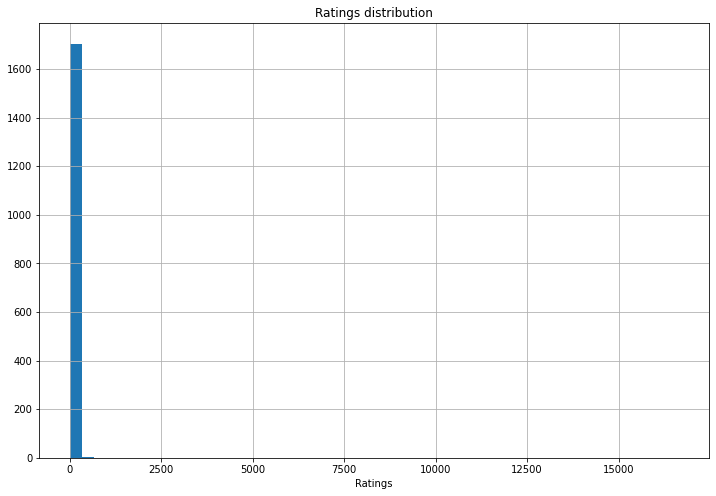

In [ ]:
import plotly.express as px

# Plot the bar graph for visualising the representation of each brand
fig = px.bar(x=training_data_sample_pd['clean_brand'].value_counts().index, y=training_data_sample_pd['clean_brand'].value_counts(), labels={'x' : 'brands', 'y':'count'})
fig.show()

# plotting a pie chart visualising the total frequenct across brands
fig = px.pie(training_data_sample_pd, names='clean_brand', values='ratings', color_discrete_sequence = px.colors.sequential.RdBu, hole = 0.4)
fig.update_traces(textposition = 'inside') # Update the tracing 
fig.show()

# Plotting the bar graph for clean_brand w.r.t ratings
fig = px.bar(data_frame=training_data_sample_pd, x='clean_brand', color='ratings')
fig.show()

# Plotting the box plot for clean brand and ratings
fig = px.box(training_data_sample_pd, x='clean_brand', y='ratings')
fig.show()

# Group the data w.r.t brand and extract the sum of ratings for each brand
grouped_data = training_data_sample_pd.groupby('clean_brand').sum('ratings') # group the data by the brands and sum the ratings
grouped_data = grouped_data.reset_index()

# Plot the distribution for the summed ratings
import matplotlib.pyplot as plt
grouped_data.hist(bins=50, column='ratings', figsize=(12,8))
plt.xlabel('Ratings')
plt.title('Ratings distribution')
plt.show()

# Recommendation Engine

## Pyspark MLlib -> ALS

In [ ]:
full_training_data_updated.show(10)

+-------------------+--------------------+-------+
|                cid|         clean_brand|ratings|
+-------------------+--------------------+-------+
|0218083012206448792|Association of Ch...|      1|
|0231051004738310108|               Bismi|      1|
|0208111005761100213|               Bismi|      1|
|0213021017392991706|               Bismi|      2|
|0208061022120241935|               Bismi|      2|
|0208101026491350493|               Bismi|      5|
|0217070004530371036|   City Super Bazaar|      1|
|0205081011354180052|   City Super Bazaar|      2|
|0212101026598751266|   City Super Bazaar|      5|
|0216081000895598221|        Golden Tulip|      1|
+-------------------+--------------------+-------+
only showing top 10 rows



In [ ]:
# Convert the string columns into index
from pyspark.ml.feature import StringIndexer

# Encode the 'cid' column
indexer_1 = StringIndexer(inputCol='cid', outputCol='cid_index')
indexed_data_1 = indexer_1.fit(full_training_data_updated).transform(full_training_data_updated)

# Encode the 'clean_brand' column 
indexer_2 = StringIndexer(inputCol='clean_brand', outputCol='clean_brand_index')
indexed_data_2 = indexer_2.fit(indexed_data_1).transform(indexed_data_1)

# Drop the original cid and clean_brand columns
final_training_data = indexed_data_2.drop('cid', 'clean_brand')

In [ ]:
final_training_data.show(10)

+-------+---------+-----------------+
|ratings|cid_index|clean_brand_index|
+-------+---------+-----------------+
|      1|   6896.0|           1903.0|
|      1|  19639.0|            959.0|
|      1|   2000.0|            959.0|
|      2|   2143.0|            959.0|
|      2|  10085.0|            959.0|
|      5|   4450.0|            959.0|
|      1|   1254.0|           1306.0|
|      2|    902.0|           1306.0|
|      5|   2139.0|           1306.0|
|      1|   5444.0|            852.0|
+-------+---------+-----------------+
only showing top 10 rows



In [ ]:
final_training_data.printSchema()

root
 |-- ratings: integer (nullable = false)
 |-- cid_index: double (nullable = false)
 |-- clean_brand_index: double (nullable = false)



In [ ]:
final_training_data = final_training_data.select('cid_index', 'clean_brand_index', 'ratings') # Rearrange the columns

In [ ]:
final_training_data_2 = final_training_data.withColumnRenamed('ratings', 'label')

In [ ]:
# Splitting the data into train and test
train, test = final_training_data_2.randomSplit([0.8, 0.2], seed = 12)

In [ ]:
# importing time modeule to measure time
import time
start_time = time.time() # store the starting time

# Creating the ALS model and hyperparamter tuning
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Build the model
als_model = ALS(maxIter=10, regParam=0.01, userCol='cid_index', itemCol='clean_brand_index', ratingCol='label', coldStartStrategy='drop') # Default model

# Create the paramgrid
param_grid = ParamGridBuilder()\
             .addGrid(als_model.maxIter, [5, 10])\
             .addGrid(als_model.regParam, [0.1, 0.01, 0.001, 0.5, 0.05])\
             .build()

# TrainValidation Split
tvs = CrossValidator(estimator = als_model,
                           estimatorParamMaps = param_grid,
                           evaluator = RegressionEvaluator(),
                          numFolds=3, ) # Taking 3 folds
# Fit the model
model = tvs.fit(train)
end_time = time.time() # Store the ending time

# Print the total time taken
total_time_taken_in_sec = end_time-start_time
print("Total time taken by the ALS model while hyperparamter tuning {:.4f}".format(total_time_taken_in_sec))

Total time taken by the ALS model while hyperparamter tuning 1780.5906


In [ ]:
# Evaluate the model (Hyperparameter Tuned)
start_test_time_1 = time.time() #  Store the start time
predictions_1 = model.transform(test) # Make predictions
end_test_time_1 = time.time() # Store the end time

total_test_time_1 = end_test_time_1 - start_test_time_1 # total time taken to test the model

# RMSE
evaluator1_HT = RegressionEvaluator(metricName='rmse') # Create Evaluator Object
rmse_HT = evaluator1_HT.evaluate(predictions_1) # Evaluate the predictions

# MAE
evaluator2_HT = RegressionEvaluator(metricName='mae') # Create Evaluator Object
mae_HT = evaluator2_HT.evaluate(predictions_1) # Evaluate the predictions

In [ ]:
# Store the result in a Dataframe
import numpy as np
import pandas as pd
als_results_HT = pd.DataFrame(np.array([rmse_HT, mae_HT, total_time_taken_in_sec, total_test_time_1]).reshape(1,4), index = ["ALS_HT"], columns=["test_rmse", "test_mae", "fit_time", "test_time"])

In [ ]:
als_results_HT

,test_rmse,test_mae,fit_time,test_time
ALS_HT,1.506533,1.017243,1780.59058,0.041729


In [ ]:
start_time_2 = time.time() # Store the starting time

als_model = ALS(userCol='cid_index', itemCol='clean_brand_index', ratingCol='label', coldStartStrategy='drop') # Default model
model = als_model.fit(train) # fit the model

end_time_2 = time.time() # Store the end time

total_time = end_time_2 - start_time_2 # Calculate the total time
# print the time taken
print("Total time taken by default ALS Model {:.3f}".format(total_time))

Total time taken by default ALS Model 41.224


In [ ]:
# Evaluate the model
start_test_time = time.time() #  Store the start time
predictions = model.transform(test) # Make predictions
end_test_time = time.time() # Store the end time

total_test_time = end_test_time - start_test_time # total time taken to test the model

# RMSE
evaluator1 = RegressionEvaluator(metricName='rmse', ) # Create Evaluator Object
rmse = evaluator1.evaluate(predictions) # Evaluate the predictions

# MAE
evaluator2 = RegressionEvaluator(metricName='mae') # Create Evaluator Object
mae = evaluator2.evaluate(predictions) # Evaluate the predictions

In [ ]:
# Store the result in a Dataframe
import numpy as np
import pandas as pd
als_results = pd.DataFrame(np.array([rmse, mae, total_time, total_test_time]).reshape(1,4), index = ["ALS"], columns=["test_rmse", "test_mae", "fit_time", "test_time"])

In [ ]:
als_results

,test_rmse,test_mae,fit_time,test_time
ALS,1.602136,1.090677,41.223584,0.031378


In [ ]:
predictions.show(10)

+---------+-----------------+-----+-----------+
|cid_index|clean_brand_index|label| prediction|
+---------+-----------------+-----+-----------+
|   3669.0|            148.0|    4|  1.2740936|
|  12750.0|            148.0|    1|  0.1541003|
|    465.0|            148.0|    1| 0.80621576|
|    543.0|            148.0|    1|  1.2150028|
|     77.0|            148.0|    1|   1.827621|
|  15141.0|            148.0|    3|  1.0995843|
|   3230.0|            148.0|    5| 0.55518353|
|    424.0|            148.0|    1|0.012645423|
|    762.0|            463.0|    1|  1.5807081|
|   1979.0|            463.0|    1|  0.8061024|
+---------+-----------------+-----+-----------+
only showing top 10 rows



## Surprise Package

In [ ]:
# Using Surprise Library
!pip install surprise

     |████████████████████████████████| 11.8MB 308kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617619 sha256=63c9dee709557c37f5a182410901db3bd62fd06ee42cf548135407738fb25df2
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
final_training_data_2.show(10)

+---------+-----------------+-----+
|cid_index|clean_brand_index|label|
+---------+-----------------+-----+
|   6896.0|           1903.0|    1|
|  19639.0|            959.0|    1|
|   2000.0|            959.0|    1|
|   2143.0|            959.0|    2|
|  10085.0|            959.0|    2|
|   4450.0|            959.0|    5|
|   1254.0|           1306.0|    1|
|    902.0|           1306.0|    2|
|   2139.0|           1306.0|    5|
|   5444.0|            852.0|    1|
+---------+-----------------+-----+
only showing top 10 rows



In [ ]:
# Convert the pyspark dataframe into pandas dataframe
full_training_data_pd = final_training_data.toPandas()

# Importing modules from the surprise package
from surprise import SVD, SlopeOne, CoClustering, NormalPredictor, KNNWithMeans # Algorithms in the surprise library
from surprise import Dataset # To load the dataset from pandas
from surprise.model_selection import train_test_split # Splitting the data
from surprise.model_selection import cross_validate # Cross validation
from surprise.reader import Reader

reader = Reader(rating_scale=(1,5)) # Creates a reader object which reads the data
data = Dataset.load_from_df(full_training_data_pd, reader) # Loads the data from pandas dataframe

In [ ]:
full_training_data_pd.head()

,cid_index,clean_brand_index,ratings
0,6896.0,1903.0,1
1,19639.0,959.0,1
2,2000.0,959.0,1
3,2143.0,959.0,2
4,10085.0,959.0,2


In [ ]:
# Model Building
import pandas as pd
benchmark = []

# Iterate over all the algorithms
for algorithm in [SVD(), SlopeOne(), CoClustering(), NormalPredictor()]:
  
  # Perform Cross Validation
  results = cross_validate(algorithm, data, cv=5, verbose=False)

  # Get the results
  tmp = pd.DataFrame.from_dict(results).mean(axis=0) # take the mean of all the cv results
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
  benchmark.append(tmp)
    
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') # Store the results in a dataframe

In [ ]:
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.952661,0.551033,5.661028,0.326523
SlopeOne,1.203223,0.866941,0.899463,0.254856
CoClustering,1.371739,0.972305,9.300871,0.200685
NormalPredictor,1.372213,0.964957,0.217955,0.250367


In [ ]:
# Concatenate the surprise_Results and the als_results
als_surprise_results = pd.concat([surprise_results, als_results, als_results_HT],axis=0).sort_values('test_rmse')

In [ ]:
als_surprise_results

,test_rmse,test_mae,fit_time,test_time
SVD,0.952661,0.551033,5.661028,0.326523
SlopeOne,1.203223,0.866941,0.899463,0.254856
CoClustering,1.371739,0.972305,9.300871,0.200685
NormalPredictor,1.372213,0.964957,0.217955,0.250367
ALS_HT,1.506533,1.017243,1780.590580,0.041729
ALS,1.602136,1.090677,41.223584,0.031378
